In [1]:
import os
import sys
import logging
import cv2
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ast import literal_eval
from tqdm import tqdm_notebook as tqdm
import numpy as np

%matplotlib inline
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('TrainClassifier')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vehicle_detector import extract_features

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Load the computer params and plot the results
with open('../data/top_models.json') as fp:
    stats =  json.load(fp)['stats']

stats = list(filter(lambda x: 'GRAY'not in x['name'], stats))
# Remove params with cells/block pix/cell not divisble by windows size
stats = list(filter(lambda x: 'C(12, 12)' not in x['name'], stats))

In [3]:
top_10_params = sorted(stats, key=lambda x: x['accuracy'],reverse=True)[:11]

accuracy = list(i ['accuracy'] for i in top_10_params)
extract_time = list(i ['extraction_time'] for i in top_10_params)
num_features = list(i ['num_features'] for i in top_10_params)
training_time = list(i ['training_time'] for i in top_10_params)
# # top_10_params

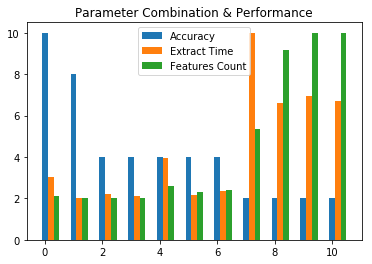

In [4]:
from sklearn.preprocessing import minmax_scale
width = 0.2

x = np.arange(len(accuracy))
plt.bar(x, minmax_scale(accuracy, feature_range=(0, 8)) + 2, width, label='Accuracy' )
plt.bar(x + width , minmax_scale(extract_time, feature_range=(0, 8)) + 2,width, label='Extract Time')
plt.bar(x + 2 * width , minmax_scale(num_features, feature_range=(0, 8)) + 2,width, label='Features Count')
plt.title('Parameter Combination & Performance')
plt.legend()
plt.show()

In [5]:
# Load  Image Paths
with open('../data/filtered_images_path.json', 'r') as fp:
    data = json.load(fp)

with open('../data/unfiltered_images_path.json', 'r') as fp:
    unfiltered_data = json.load(fp)

vehicle_images_path = data['vehicle_images']
non_vehicle_images_path = data['non_vehicle_images']

uf_vehicle_images_path = unfiltered_data['vehicle_images']
uf_non_vehicle_images_path = unfiltered_data['non_vehicle_images']

In [6]:
params_desc = map(lambda x: x['name'], top_10_params)

def get_dataset_name_from_params(params, hog_params, is_unfiltered=False):
    model_desc = 'A_{acc}_C_{c_val}_gamma_{gamma_val}'.format(acc=params['accuracy'],
                    c_val=params['best_params']['C'], gamma_val=params['best_params']['gamma'])
    param_desc= 'CH_{hist}_O_{orients}_P_{n_pixels}_C_{n_cells}_CS_{cspace}'.format(
        hist=hog_params['color_hist'], orients=hog_params['orientations'],
        n_pixels=hog_params['pixels_per_cell'], n_cells=hog_params['cells_per_block'],
        cspace=hog_params['hog_color_space'])
    name = '{model}_{hog}.hdf5'.format(model=model_desc, hog=param_desc)
    if is_unfiltered:
        name = 'unfiltered_{name}'.format(name=name)
    return name

def get_feature_params(params_desc):
    tokens = params_desc.split('_')
    return {
        'hog_color_space': tokens[1],
        'pixels_per_cell': literal_eval(tokens[2][1:]),
        'cells_per_block': literal_eval(tokens[3][1:]),
        'orientations': literal_eval(tokens[4][1:]),
        'color_hist': literal_eval(tokens[6])
    }


In [7]:
postive_samples = vehicle_images_path[:]
negative_samples = non_vehicle_images_path[:]

dataset_dir = '../data/datasets'

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
        
for params in tqdm(top_10_params, desc='Creating Datasets'):
    feature_params = get_feature_params(params['name'])
    dataset_name = get_dataset_name_from_params(params, feature_params)
    dataset_path = os.path.join(dataset_dir, dataset_name)
    extract_features.extract_save_features(postive_samples, negative_samples, feature_params,
                                          dataset_path, 'carnd_p5')



INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/A_99.5_C_10_gamma_auto_CH_True_O_12_P_(16, 16)_C_(4, 4)_CS_BGR2YCrCb.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/A_99.375_C_10_gamma_auto_CH_True_O_10_P_(16, 16)_C_(4, 4)_CS_BGR.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/A_99.125_C_10_gamma_auto_CH_True_O_9_P_(16, 16)_C_(4, 4)_CS_BGR2YCrCb.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/A_99.125_C_10_gamma_auto_CH_True_O_10_P_(16, 16)_C_(4, 4)_CS_BGR2YCrCb.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/A_99.125_C_10_gamma_auto_CH_True_O_12_P_(16, 16)_C_(2, 2)_CS_BGR2HSV.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset 

In [ ]:
uf_postive_samples = uf_vehicle_images_path[:]
uf_negative_samples = uf_non_vehicle_images_path[:]

for params in tqdm(top_10_params, desc='Creating Datasets'):
    feature_params = get_feature_params(params['name'])
    dataset_name = get_dataset_name_from_params(params, feature_params, is_unfiltered=True)
    dataset_path = os.path.join(dataset_dir, dataset_name)
    extract_features.extract_save_features(uf_postive_samples, uf_negative_samples, feature_params,
                                          dataset_path, 'carnd_p5')



INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/unfiltered_A_99.5_C_10_gamma_auto_CH_True_O_12_P_(16, 16)_C_(4, 4)_CS_BGR2YCrCb.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/unfiltered_A_99.375_C_10_gamma_auto_CH_True_O_10_P_(16, 16)_C_(4, 4)_CS_BGR.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/unfiltered_A_99.125_C_10_gamma_auto_CH_True_O_9_P_(16, 16)_C_(4, 4)_CS_BGR2YCrCb.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/unfiltered_A_99.125_C_10_gamma_auto_CH_True_O_10_P_(16, 16)_C_(4, 4)_CS_BGR2YCrCb.hdf5 with name carnd_p5
INFO:vehicle_detector.extract_features:Successfully wrote dataset to file at ../data/datasets/unfiltered_A_99.125_C_10_gamma_auto_CH_True_O_12_P_(16, 16)_C_(2, 2)_CS_BGR2HSV.hdf5 with name carnd_p5
INFO:vehicl